https://towardsdatascience.com/getting-started-with-gaussian-process-regression-modeling-47e7982b534d

In [100]:
from sklearn.model_selection import train_test_split
import pandas as pd
from rdkit import Chem
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

import plotly.express as px

from mordred import Chi, ABCIndex, RingCount, Calculator,MoeType,AcidBase
from mordred import Calculator, descriptors

In [77]:

n_all = len(Calculator(descriptors, ignore_3D=False).descriptors)
n_2D = len(Calculator(descriptors, ignore_3D=True).descriptors)
n_all, n_2D
#calc = Calculator(descriptors, ignore_3D=True)
calc = Calculator()
# Register descriptor instance
#calc.register(Chi)
#calc.register(RingCount.RingCount)
#calc.register(ABCIndex)
calc.register(MoeType)
calc.register(AcidBase)
print(calc.descriptors)

(mordred.MoeType.LabuteASA(), mordred.MoeType.PEOE_VSA(1), mordred.MoeType.PEOE_VSA(2), mordred.MoeType.PEOE_VSA(3), mordred.MoeType.PEOE_VSA(4), mordred.MoeType.PEOE_VSA(5), mordred.MoeType.PEOE_VSA(6), mordred.MoeType.PEOE_VSA(7), mordred.MoeType.PEOE_VSA(8), mordred.MoeType.PEOE_VSA(9), mordred.MoeType.PEOE_VSA(10), mordred.MoeType.PEOE_VSA(11), mordred.MoeType.PEOE_VSA(12), mordred.MoeType.PEOE_VSA(13), mordred.MoeType.SMR_VSA(1), mordred.MoeType.SMR_VSA(2), mordred.MoeType.SMR_VSA(3), mordred.MoeType.SMR_VSA(4), mordred.MoeType.SMR_VSA(5), mordred.MoeType.SMR_VSA(6), mordred.MoeType.SMR_VSA(7), mordred.MoeType.SMR_VSA(8), mordred.MoeType.SMR_VSA(9), mordred.MoeType.SlogP_VSA(1), mordred.MoeType.SlogP_VSA(2), mordred.MoeType.SlogP_VSA(3), mordred.MoeType.SlogP_VSA(4), mordred.MoeType.SlogP_VSA(5), mordred.MoeType.SlogP_VSA(6), mordred.MoeType.SlogP_VSA(7), mordred.MoeType.SlogP_VSA(8), mordred.MoeType.SlogP_VSA(9), mordred.MoeType.SlogP_VSA(10), mordred.MoeType.SlogP_VSA(11), mordr

In [78]:
df = pd.read_csv(r"/NEWDATA/moldata/opera_physprop/OPERA_BP/TR_BP_4077.csv")
df_test = pd.read_csv(r"/NEWDATA/moldata/opera_physprop/OPERA_BP/TST_BP_1358.csv")
df_add = pd.DataFrame([{"SMILES": "O", "BP": 100}])
df = pd.concat([df,df_add],axis=0)
df

,SMILES,BP
0,C=O,-19.10
1,c1c2ccccc2c2ccc3cccc4ccc1c2c34,495.00
2,OC(=O)c1cc(Cl)ccc1Cl,301.00
3,C[C@H](N)Cc1ccccc1,203.00
4,CCOC(N)=O,185.00
...,...,...
4073,CCCOC(=O)c1cocc1,210.90
4074,CCC(O)CCC(F)(F)F,140.65
4075,FC(F)(Cl)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,151.00
4076,FC(F)(Br)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,159.00


In [79]:
def compute_descriptors(df, smiles_column='SMILES', target_column=None):
    """
    Computes molecular descriptors 
    
    Parameters:
    - df (pandas.DataFrame): The input DataFrame containing SMILES strings and target values.
    - smiles_column (str): The name of the column in `df` that contains the SMILES strings. Default is 'SMILES'.
    - target_column (str): The name of the column in `df` that contains the target values. Default is 'BP'.

    Returns:
    - X (numpy.ndarray): A NumPy array of computed descriptors with NaN columns removed.
    - y (pandas.Series): The target values corresponding to each row in `X`.
    """
    # Assuming calc is a function or callable object that computes descriptors for an RDKit molecule
    mols = [Chem.MolFromSmiles(smi) for smi in df[smiles_column]]
    X = [calc(mol) for mol in mols]
    X = np.array(X).astype(np.float64)
    if target_column: 
        y = df[target_column]
    else: 
        y = None

    nan_dims = []
    for i in range(len(X)):
        nan_indices = list(np.where(np.isnan(X[i, :]))[0])
        for dim in nan_indices:
            if dim not in nan_dims:
                nan_dims.append(dim)

    X = np.delete(X, nan_dims, axis=1)
    
    return X, y


In [80]:
%%time
X, y = compute_descriptors(df,target_column='BP')

CPU times: user 3.01 s, sys: 0 ns, total: 3.01 s
Wall time: 4.07 s


In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [82]:
%%time
kernel = ConstantKernel(1.0) + ConstantKernel(1.0) * RBF(10)  + WhiteKernel(5)
model = GaussianProcessRegressor(kernel=kernel)
model.fit(X_train, y_train)
y_pred_tr, y_pred_tr_std = model.predict(X_train, return_std=True)

CPU times: user 13min 56s, sys: 16min 19s, total: 30min 16s
Wall time: 3min 42s


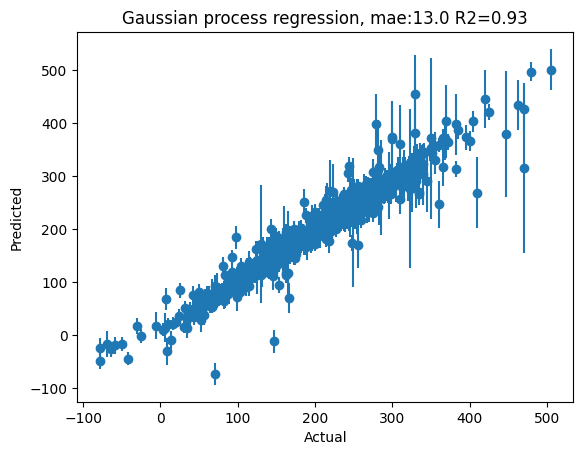

In [83]:
def evaluate(model, X_test,y_test):
    y_pred_te, y_pred_te_std = model.predict(X_test, return_std=True)
    plt.figure()
    plt.errorbar(y_test, y_pred_te, yerr=y_pred_te_std, fmt='o')
    r2 = r2_score(y_test, y_pred_te)
    mae = mean_absolute_error(y_test, y_pred_te)
    plt.title(f"Gaussian process regression, mae:{mae:.1f} R2={r2:.2f}" )
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
evaluate(model,X_test,y_test)

(1358, 55) (1358,)


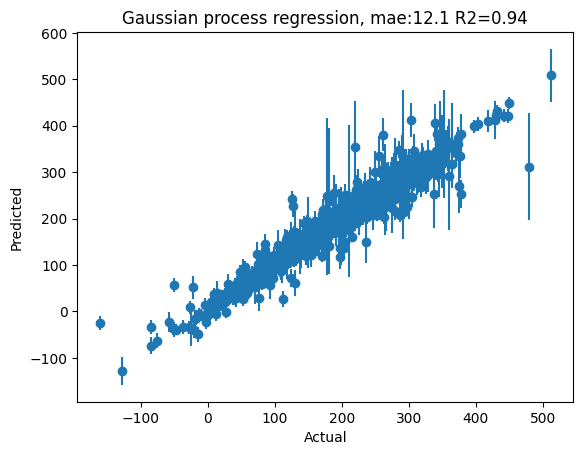

In [88]:
Xval,yval = compute_descriptors(df_test,target_column='BP')
print(Xval.shape,yval.shape)
evaluate(model,Xval,yval)

In [85]:
# mae 12.7 R^2: 0.94
# mae 13.3 R^2: 0.93  Moe-type, acid-base, ringcount

In [107]:
def predict_boiling_point(smiles_list,experiments=None):
    smiles_list = smiles_list.split("\n")
    mols = [Chem.MolFromSmiles(smi) for smi in smiles_list]
    X = [calc(mol) for mol in mols]
    X = np.array(X).astype(np.float64)
    y_pred_te, y_pred_te_std = model.predict(X, return_std=True)
    df = pd.DataFrame({"SMILES": smiles_list, "bp,predicted": y_pred_te, "+/-": y_pred_te_std})
    fig = None
    if experiments:
        experiments = experiments.split("\n")
        df['bp,exp'] = experiments
        df['bp,exp'] = df['bp,exp'].astype(float)
        fig = px.scatter(df, x="bp,predicted", y="bp,exp",  hover_data=["SMILES"],
                 error_y="+/-")
    tmpfile = "results.csv"
    df.to_csv(tmpfile)
    return df,tmpfile,fig
compounds = """
CC(=O)Nc1ccc(cc1)OC
CC(=O)Nc1cc2Cc3ccccc3-c2cc1
NC(=O)c1ccccc1
CCOP(=S)(Oc1ccc(cc1)[N+]([O-])=O)OCC
CCCCCCCCCCCCCCCC(O)=O
CC(O)CO
O=NN1CCOCC1
CCOCC
CN1C=CNC1=S
CCOS(C)(=O)=O
CNC(=O)Oc1cccc2ccccc21
CCO
OC(=O)c1ccccc1
Cc1cc(C)[nH][n]1
CC(C)=O
CN(C)C=O
CCCCO
COc1ccc(cc1)C(c1ccc(cc1)OC)C(Cl)(Cl)Cl
C
C#C
C#N
ClCBr
C=CCl
CC#N
FCF
CSC
O
"""
predict_boiling_point(compounds)

(                                    SMILES  bp,predicted        +/-
 0                                             -75.834730  16.872891
 1                      CC(=O)Nc1ccc(cc1)OC    305.908648  16.610701
 2              CC(=O)Nc1cc2Cc3ccccc3-c2cc1    412.483295  35.751385
 3                           NC(=O)c1ccccc1    263.597595  16.396490
 4     CCOP(=S)(Oc1ccc(cc1)[N+]([O-])=O)OCC    271.051323  58.814706
 5                    CCCCCCCCCCCCCCCC(O)=O    322.674091  15.650211
 6                                  CC(O)CO    197.504149  12.897308
 7                              O=NN1CCOCC1    250.439225  27.204655
 8                                    CCOCC     37.387251  12.123862
 9                              CN1C=CNC1=S    242.726087  19.017353
 10                           CCOS(C)(=O)=O    191.269675  15.197035
 11                  CNC(=O)Oc1cccc2ccccc21    282.501294  24.658369
 12                                     CCO     85.135678  11.996928
 13                          OC(=O

In [108]:
import gradio as gr
demo = gr.Interface(
    fn=predict_boiling_point,
    inputs=[gr.TextArea(),gr.TextArea()],
    outputs=[gr.DataFrame(),gr.File(),gr.Plot()],
)
demo.launch()

Running on local URL:  http://127.0.0.1:7874

To create a public link, set `share=True` in `launch()`.
